In [1]:
# Importing data from the r/politics
from psaw import PushshiftAPI
from datetime import datetime, timezone, date
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm, tqdm_pandas
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\JaQtae\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# WordCloud per candidate

In [2]:
# Downloading all the comments data (processed)
#url = 'https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_comments_very_smol_fully_processed.csv'
local_storage = local_storage = r"C:\Users\JaQtae\Desktop\SocInfo2022\Data\com_data_50plusComments_pruned_30plusComments.csv"
com_data = pd.read_csv(local_storage,index_col=0,parse_dates=[0])
com_data.index = com_data.index.rename('dates')
# The collected comments data set still contained some data from 2020-09-30. This is removed. 

# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)
com_data

id    link_id  score           author   parent_id  \
dates                                                                         
2020-11-03 00:23:36  gaycvmz  t3_jmybs3      1        yyungpiss   t3_jmybs3   
2020-11-02 23:26:26  gay6kwb  t3_jmybs3      1     J_Class_Ford  t1_gay5x5w   
2020-11-02 23:20:27  gay5x5w  t3_jmybs3      1        cyanydeez  t1_gay5pjk   
2020-11-02 23:18:33  gay5pjk  t3_jmybs3      1     J_Class_Ford  t1_gay5doq   
2020-11-02 23:15:36  gay5doq  t3_jmybs3      1        cyanydeez  t1_gay3si8   
...                      ...        ...    ...              ...         ...   
2020-10-01 01:25:30  g78ozrz  t3_j2vwwt      1    5DollarHitJob   t3_j2vwwt   
2020-10-01 01:24:25  g78ovcd  t3_j2vwwt      1      AmishTechno   t3_j2vwwt   
2020-10-01 00:29:42  g78j6ey  t3_j2vwwt      1   ryhaltswhiskey  t1_g78iult   
2020-10-01 00:07:18  g78gwrv  t3_j2vwwt      1  GrumpyOlBastard   t3_j2vwwt   
2020-10-01 00:00:36  g78g8dl  t3_j2vwwt      1   maybe-fuck-you   t3_j2vwwt   

                                                                  body  \
dates                                                                    
2020-11-03 00:23:36  is there some sort of weird strategy to this o...   
2020-11-02 23:26:26                             Division is his weapon   
2020-11-02 23:20:27  dunno, everything trump does seems to generate...   
2020-11-02 23:18:33  Not sure it generates many more votes. I work ...   
2020-11-02 23:15:36  yeah, but for every vote this generates, would...   
...                                                                ...   
2020-10-01 01:25:30                         Can they just appeal this?   
2020-10-01 01:24:25                          And, nothing will happen.   
2020-10-01 00:29:42  Ah I did not know that\r\n\r\nMan I hope Barr ...   
2020-10-01 00:07:18  So I’m wondering what’s going to happen when n...   
2020-10-01 00:00:36                              My report I paid for.   

                    parent_author  \
dates                               
2020-11-03 00:23:36        geoxol   
2020-11-02 23:26:26     cyanydeez   
2020-11-02 23:20:27  J_Class_Ford   
2020-11-02 23:18:33     cyanydeez   
2020-11-02 23:15:36  J_Class_Ford   
...                           ...   
2020-10-01 01:25:30    Plymouth03   
2020-10-01 01:24:25    Plymouth03   
2020-10-01 00:29:42   memepolizia   
2020-10-01 00:07:18    Plymouth03   
2020-10-01 00:00:36    Plymouth03   

                                                                tokens  \
dates                                                                    
2020-11-03 00:23:36  ['sort', 'weird', 'strategy', 'something', 'la...   
2020-11-02 23:26:26                             ['division', 'weapon']   
2020-11-02 23:20:27  ['dunno', 'everything', 'trump', 'seems', 'gen...   
2020-11-02 23:18:33  ['not', 'sure', 'generates', 'many', 'votes', ...   
2020-11-02 23:15:36  ['yeah', 'every', 'vote', 'generates', 'would'...   
...                                                                ...   
2020-10-01 01:25:30                                  ['can', 'appeal']   
2020-10-01 01:24:25                       ['and', 'nothing', 'happen']   
2020-10-01 00:29:42  ['ah', 'i', 'know', 'man', 'i', 'hope', 'barr'...   
2020-10-01 00:07:18  ['so', 'i', 'wondering', 'going', 'happen', 'n...   
2020-10-01 00:00:36                      ['my', 'report', 'i', 'paid']   

                    politician children_comments mentions_Trump mentions_Biden  
dates                                                                           
2020-11-03 00:23:36      Trump                []            NaN            NaN  
2020-11-02 23:26:26      Trump                []            NaN            NaN  
2020-11-02 23:20:27      Trump       ['gay6kwb']           True            NaN  
2020-11-02 23:18:33      Trump       ['gay5x5w']           True            NaN  
2020-11-02 23:15:36      Trump       ['gay5pjk']            NaN            NaN  
...                    

In [3]:
author_bodies = com_data.groupby(["politician"]).apply(lambda x: x["body"].unique())
author_bodies

politician
Biden    [I'm crazy. I'm not evil. I'm just like many o...
Trump    [is there some sort of weird strategy to this ...
dtype: object

In [4]:
trump_corpus = " ".join(author_bodies["Trump"])
biden_corpus = " ".join(author_bodies["Biden"])

In [5]:
# We solve this by defining the clean_tokens function below.
# Define stop words to also include punctuation
import nltk
stop = set(stopwords.words('english') + list(string.punctuation))

# Function to tokenize and clean the text of each submission
def clean_tokens(text):
    tokens = nltk.word_tokenize(text)
    # In the list comprehension below, we exclude URL's, stopwords and numbers as well as setting all characters to lowercase
    
    clean_tokens = [re.sub(r'http\S+', '', str(i)).lower() for i in tokens if str(i).isalpha()]
    clean_tokens = [re.sub(r'&\S+', '', str(i)) for i in clean_tokens]
    clean_tokens = [t for t in clean_tokens if t not in stop]
    return clean_tokens

TTC = clean_tokens(trump_corpus)
TBC = clean_tokens(biden_corpus)

In [6]:
TTC_j = " ".join(TTC)
TBC_j = " ".join(TBC)
# Hader regex
TTC_j = TTC_j.replace(' gt', '')
TTC_j = TTC_j.replace(' amp', '')
TBC_j = TBC_j.replace(' gt', '')
TBC_j = TBC_j.replace(' amp', '')

In [7]:
TTC_j

'sort weird strategy something lashing like toddler division weapon dunno everything trump seems generate resistance sure generates many votes work assumption majority anti maskers covid deniers armed fruit loops trump supporters motivation base yeah every vote generates would think created really believe idiot trying lose purpose fauci obama hillary currently running president trumps head wo enough right millions despise still watch listen amount attention thing irrelevant despite wild fears tyrant loves power possible overestimate may realize ever mattered approval wants people think great winner good enough dad would proud cocooned center tells left white house amazing guy insane fraudulent election maybe narrative millions followers enough maybe go donald trump followers create violence election trump losses trump never concede republican enablers stay quiet military must intervene maintain law order obama speaking miami said loves talk crowd size bigger let go man maybe nobody cam

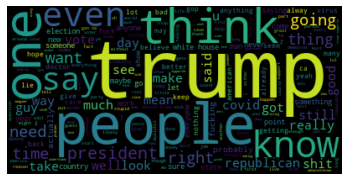

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud().generate(TTC_j)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

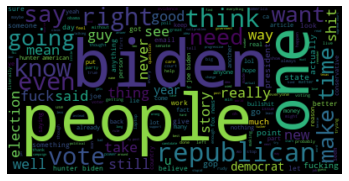

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
wc = WordCloud().generate(TBC_j)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Week 7 based
## Had to clean tokens, as they werent properly cleaned. This has been fixed at a later date, so one can replace cleaned_tokens with tokens and proceed.

In [10]:
com_data['cleaned_tokens'] = com_data['body'].progress_apply(lambda x: clean_tokens(x))

100%|████████████████████████████████████████████████████████████████████████| 104663/104663 [00:32<00:00, 3189.32it/s]


In [11]:
com_data['date'] = com_data.index
com_data['test'] = com_data['date'].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").strftime('%Y-%m-%d'))

In [12]:
documents_per_day = com_data.groupby("test").cleaned_tokens.sum()

In [13]:
for i in tqdm(range(len(documents_per_day))):
    
    #Remove gt's and amp's
    c1 = documents_per_day[i].count('gt')
    c2 = documents_per_day[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            documents_per_day[i].remove('gt')
            documents_per_day[i].remove('amp')
        except Exception:
            pass
        
    #Remove nothings
    c3 = documents_per_day[i].count('')
    for j in range(0,c3):
        try:
            documents_per_day[i].remove('')
        except Exception:
            pass


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  4.09it/s]


# Log-scaled for better viewablity.
Here we see the "rule-of-thumb" of having 10,000 tokens per document in order to use dictionary based methods is applicable to the comments data set. (The submissions only contain the article url, and no selftext)

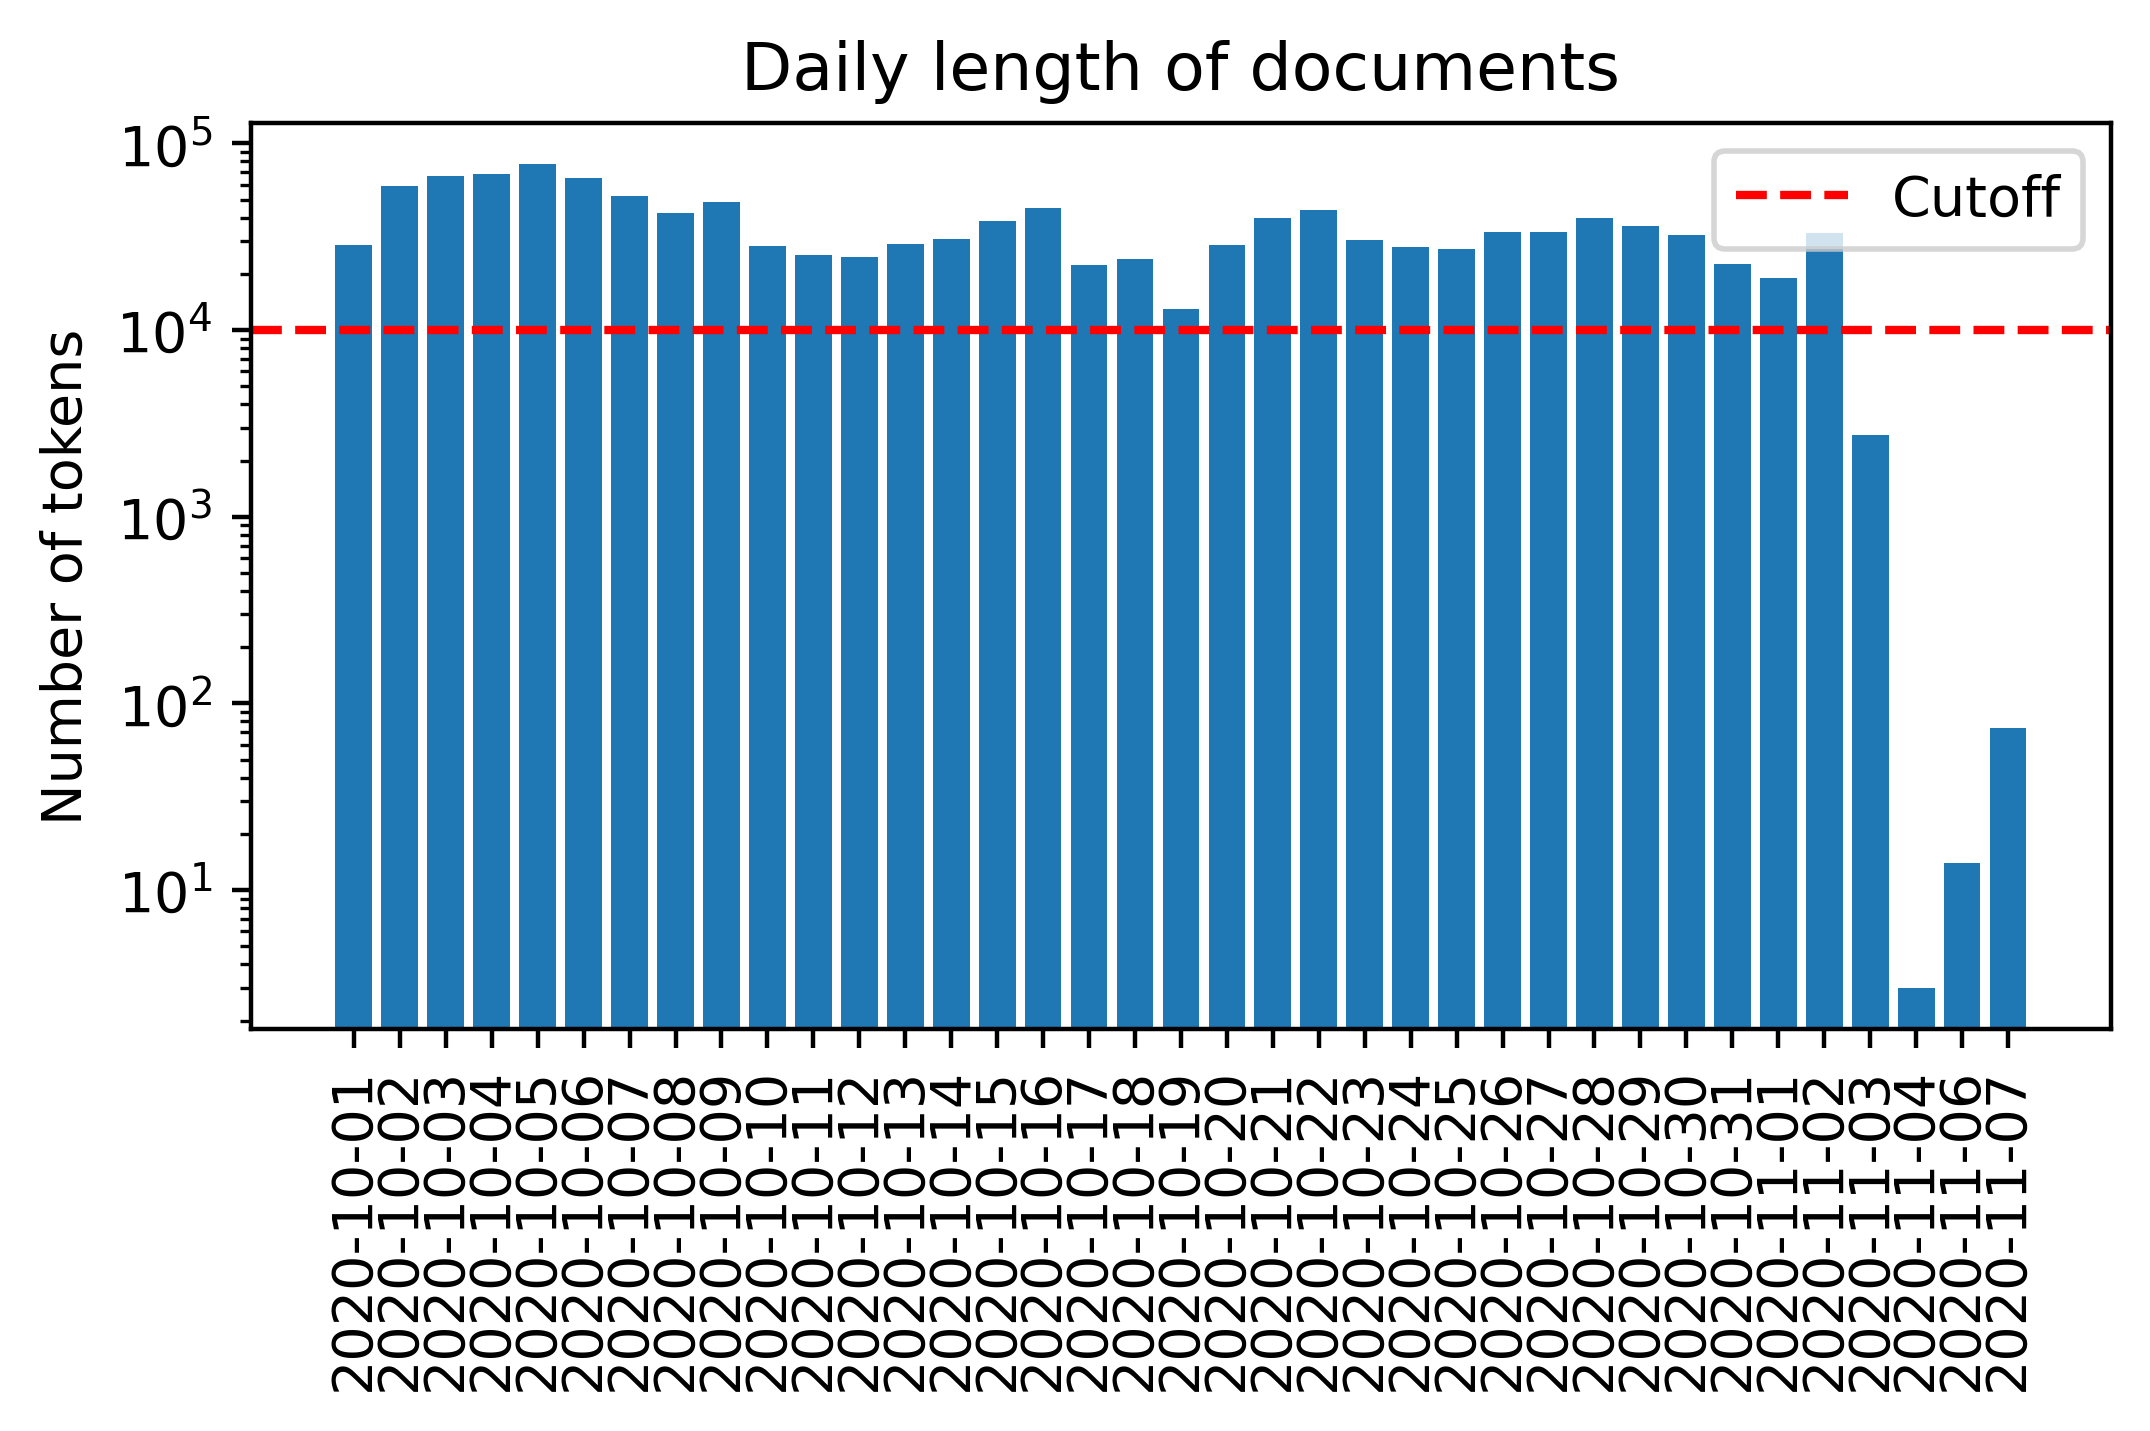

In [14]:
fig, ax = plt.subplots(figsize=(6,3), dpi=400)
plt.xticks(rotation='vertical')
ax.bar(documents_per_day.index, [len(doc) for doc in documents_per_day])
ax.set_title("Daily length of documents")
ax.axhline(10000, color="red", linestyle="dashed", label="Cutoff")
ax.set_ylabel("Number of tokens")
ax.set_yscale('log')
ax.legend()

# Week 7 happiness scores

In [15]:
labMT = pd.read_csv(r"C:\Users\JaQtae\Desktop\SocInfo2022\Hedonometer.csv", index_col="Word")

In [16]:
def hscore(tokens, p=False):
    #Iterative counter
    # If we want print p = True.
    score = 0
    freq_dict = dict(nltk.FreqDist(tokens))
    freq_norm = 0
    for word in tokens:
        # Count for word in dict
        try:
            score += labMT.loc[[word]]["Happiness Score"].values[0] * freq_dict[word]
            freq_norm += freq_dict[word]
        except:
            #Doesnt exist in labMT
            None
    hscore = score / (freq_norm+1e-06) #NaN for 0-division
    if p==True:
        return print("Happiness score: {}".format(hscore))
    else:
        return hscore


In [17]:
temp = com_data.groupby(['test', 'politician']).cleaned_tokens.sum()
for i in tqdm(range(len(temp))):
    c1 = temp[i].count('gt')
    c2 = temp[i].count('amp')
    k = max(c1, c2)
    for j in range(0,k):
        try:
            temp[i].remove('gt')
            temp[i].remove('amp')
        except Exception:
            pass

    c3 = temp[i].count('')
    for j in range(0,c3):
        try:
            temp[i].remove('')
        except Exception:
            pass

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:06<00:00, 10.29it/s]


In [18]:
trump_temp = []
biden_temp = []
ddd = temp.index
#Samler det til et stort corpus for hver kandidat
#Det er vel ikke det vi vil
#Vi vil gerne se på udviklingen af hscore over tid
for k in range(len(temp)):
    if ddd[k].count('Trump') == 1:
        trump_temp.append(temp[k])
    elif ddd[k].count('Biden') == 1:
        biden_temp.append(temp[k])
    else:
        pass
trump_temp = [item for sublist in trump_temp for item in sublist]

In [19]:
len(trump_temp)

1052016

In [20]:
temp

test        politician
2020-10-01  Biden         [min, town, hall, joe, biden, televised, every...
            Trump         [like, mic, cut, donnie, bad, gavin, mcinnes, ...
2020-10-02  Biden         [radical, left, fnck, right, wing, media, self...
            Trump         [susan, collins, cares, votes, time, democrats...
2020-10-03  Biden         [hey, look, man, aspires, president, actual, t...
                                                ...                        
2020-11-03  Trump         [sort, weird, strategy, something, lashing, li...
2020-11-04  Biden                                   [well, horse, surprise]
2020-11-06  Trump         [stay, school, ca, tell, understand, statistic...
2020-11-07  Biden         [simply, know, neither, dust, settles, many, r...
            Trump         [government, got, capone, income, tax, evasion...
Name: cleaned_tokens, Length: 72, dtype: object

In [22]:
P_daily_hscore = temp.progress_apply(lambda x: hscore(x))
P_daily_hscore.index = temp.index

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [09:04<00:00,  7.56s/it]


In [23]:
P_daily_hscore

test        politician
2020-10-01  Biden         5.633726
            Trump         5.548633
2020-10-02  Biden         5.687674
            Trump         5.445589
2020-10-03  Biden         5.715097
                            ...   
2020-11-03  Trump         5.413970
2020-11-04  Biden         6.966664
2020-11-06  Trump         5.420000
2020-11-07  Biden         5.214694
            Trump         5.463000
Name: cleaned_tokens, Length: 72, dtype: float64

In [ ]:
# Convert to csv for ease of plotting
#P_daily_hscore.to_csv("P_daily_hscore.csv")

In [24]:
B_hscores = []
T_hscores = []
for q in range(len(P_daily_hscore)):
    if P_daily_hscore.index[q].count('Biden') == 1:
        B_hscores.append(P_daily_hscore[q])
    elif P_daily_hscore.index[q].count('Trump') == 1:
        T_hscores.append(P_daily_hscore[q])
    else:
        pass

In [25]:
len(B_hscores) == len(T_hscores)

True

In [26]:
#Rod
rolled3_B = pd.Series(B_hscores).rolling(3).mean()
rolled3_T = pd.Series(T_hscores).rolling(3).mean()

In [27]:
#At gøre det uden at lave det på samme format som i Week7 er noget møg
#Så laver en dataframe med Bidens happiness scores og en med trumps så de kan plottes hver især
df_B = pd.DataFrame()
df_T = pd.DataFrame()

In [28]:
df_B['B_hscore'] = B_hscores
df_T['T_hscore'] = T_hscores

In [29]:
catcher = []
tester = []
for k in range(len(P_daily_hscore)):
    if P_daily_hscore.index[k].count('Biden') == 1:
        catcher.append(P_daily_hscore.index[k][0])
    elif P_daily_hscore.index[k].count('Trump') == 1:
        tester.append(P_daily_hscore.index[k][0])

In [30]:
#De har ikke samme datoer, det er konflikt efter valgdagen
#Skal måske fjernes fra denne her del af analysen?
length = len(catcher)                    # STEP 1

for i in range(0, length):              # STEP 2
    if catcher[i] != tester[i]:
        print('Conflicting dates at place {} out of {}: {} vs {}'.format(i,length,catcher[i],tester[i]))
    else:
        pass

Conflicting dates at place 34 out of 36: 2020-11-04 vs 2020-11-06


In [31]:
df_B.index = catcher
df_T.index = tester
df_B.head()

B_hscore
2020-10-01  5.633726
2020-10-02  5.687674
2020-10-03  5.715097
2020-10-04  5.714744
2020-10-05  5.615180

In [32]:
df_T.head()

T_hscore
2020-10-01  5.548633
2020-10-02  5.445589
2020-10-03  5.488126
2020-10-04  5.510104
2020-10-05  5.489804

In [ ]:
#df_B.rolling(3).mean()

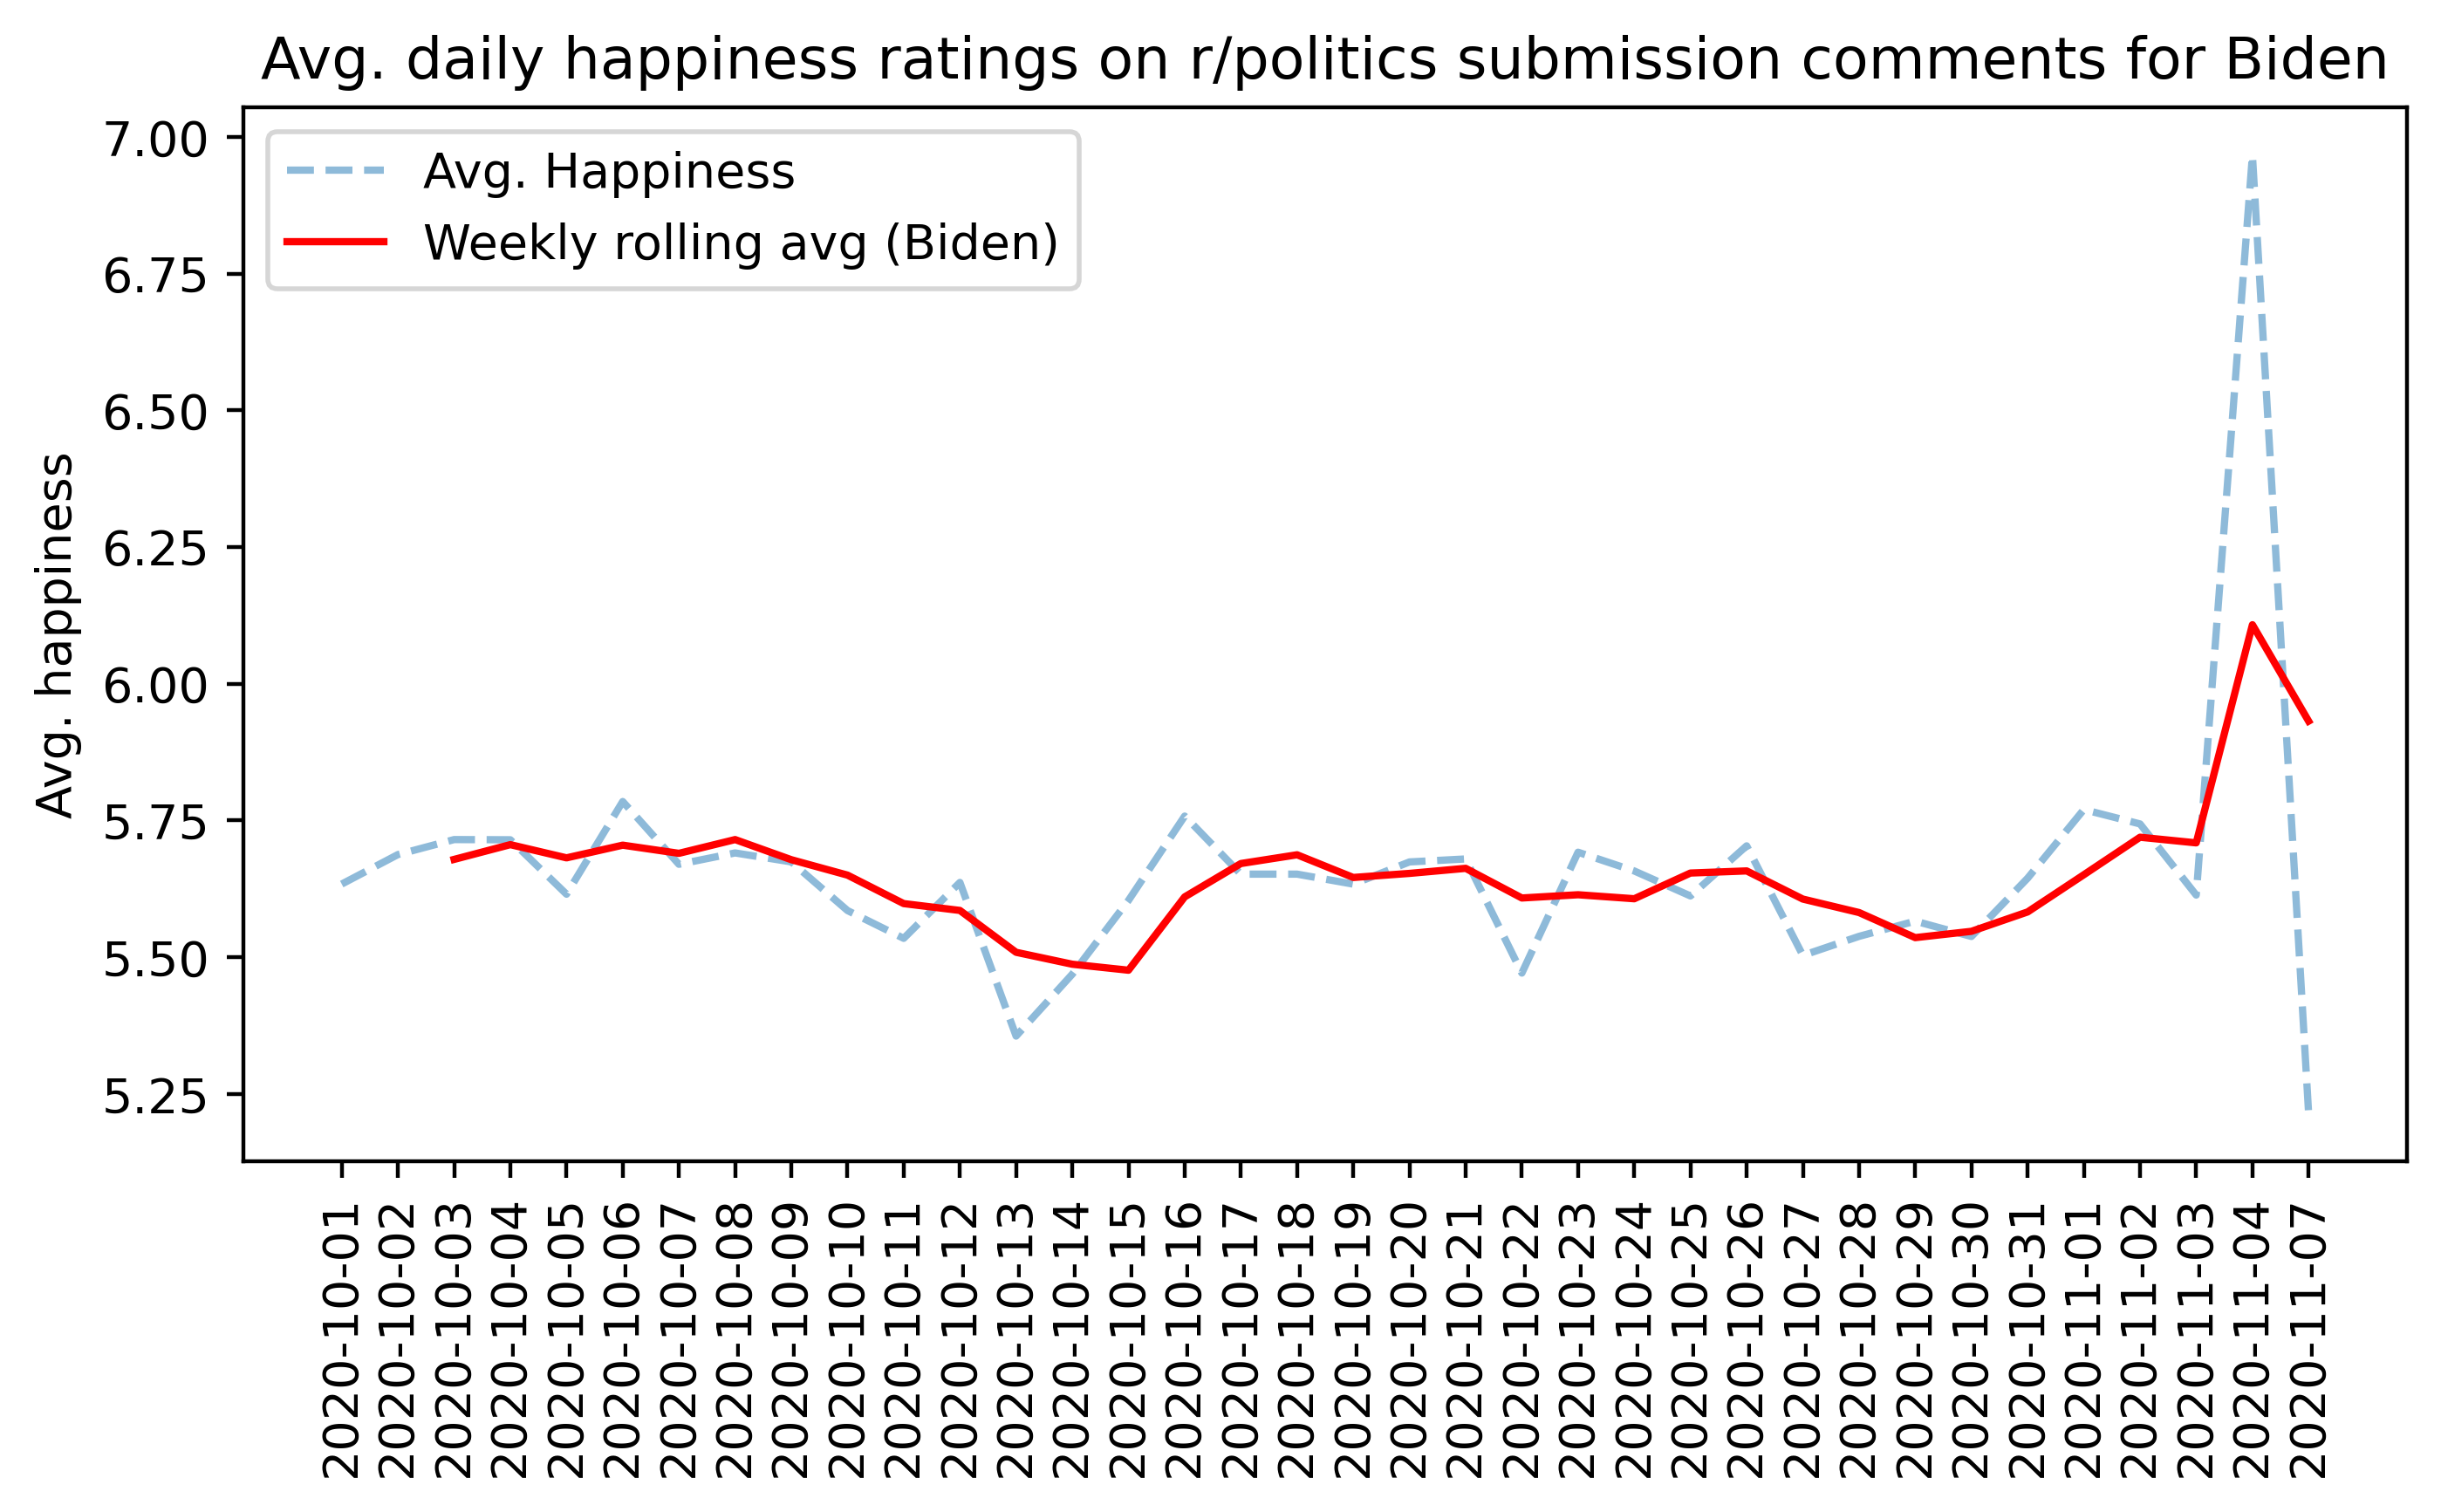

In [33]:
# Reuse from Week 2 including rolling averages
fig, ax = plt.subplots(figsize=(8,4), dpi=400)
plt.xticks(rotation='vertical')
rolling_avg_B = df_B.rolling(3).mean() # 3-day rolling average
ax.plot(df_B.index, df_B, ls = "--", alpha = 0.5, label='Avg. Happiness')
ax.plot(rolling_avg_B.index, rolling_avg_B.values, color = "r", label='Weekly rolling avg (Biden)')
ax.set_title("Avg. daily happiness ratings on r/politics submission comments for Biden")
ax.set_ylabel("Avg. happiness")
ax.legend()
#Kan nok godt bruge en AB-line ved election day
#Spike

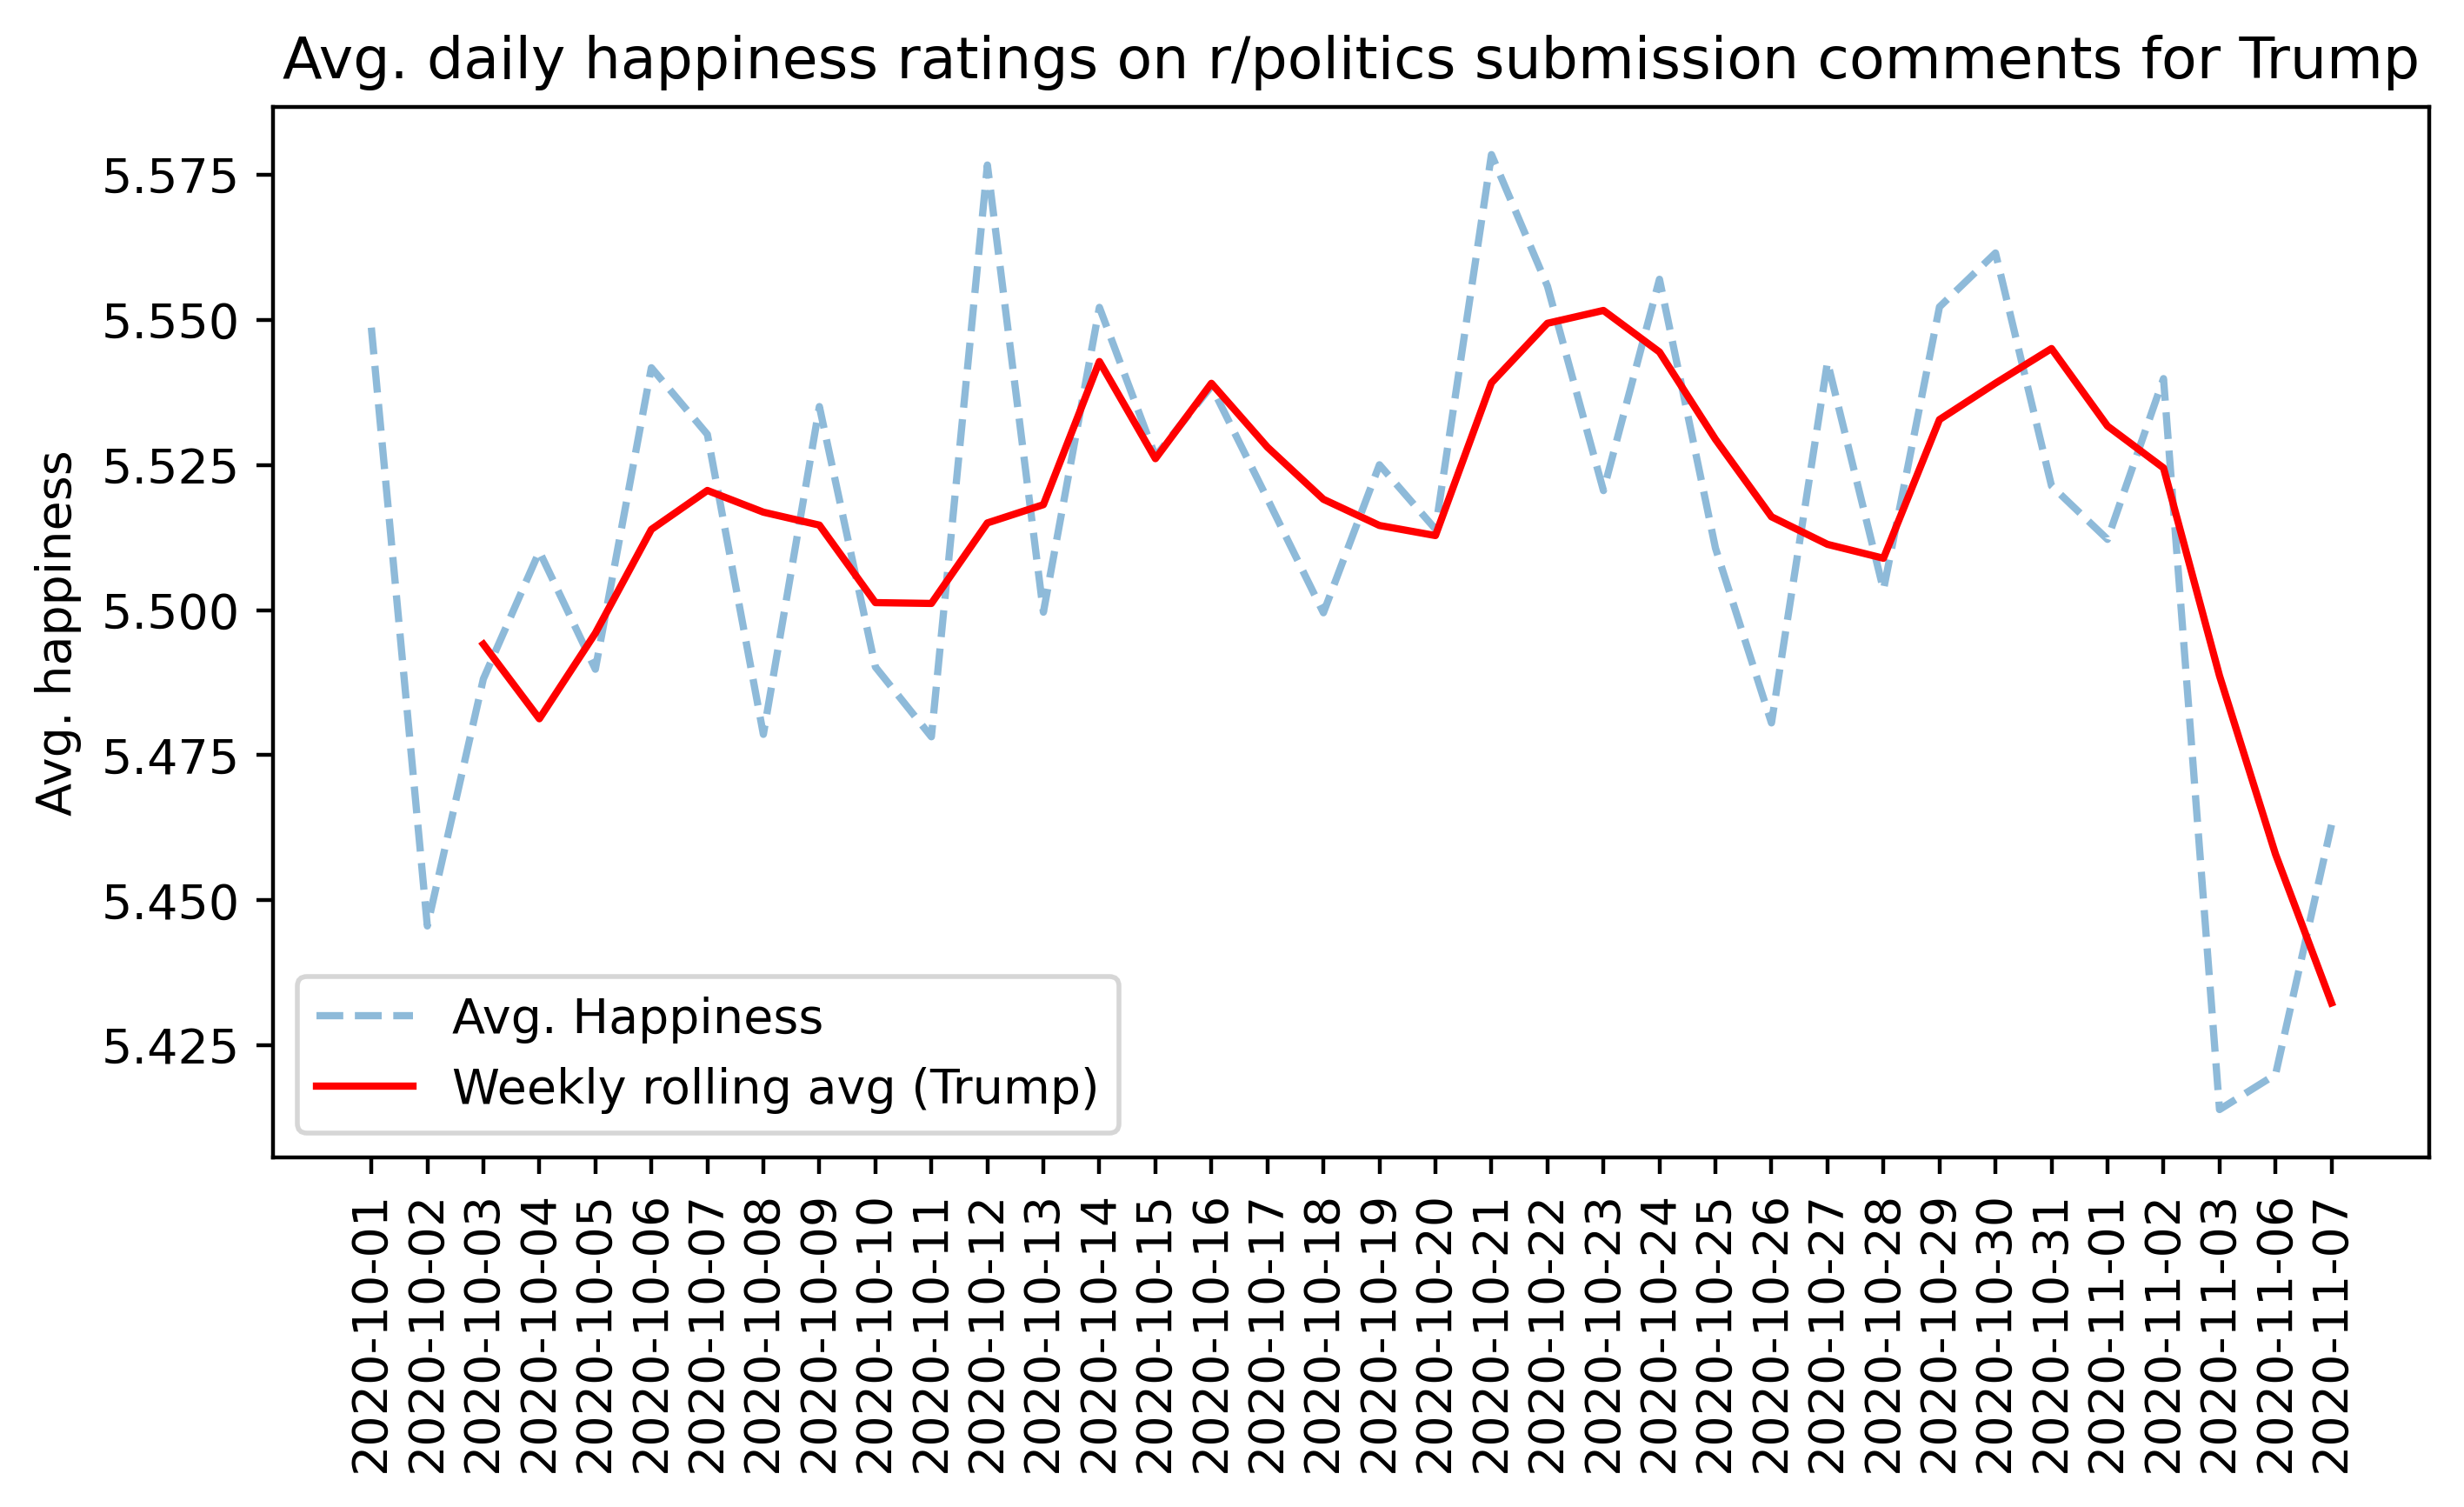

In [34]:
# Reuse from Week 2 including rolling averages
fig, ax = plt.subplots(figsize=(8,4), dpi=400)
plt.xticks(rotation='vertical')
rolling_avg_T = df_T.rolling(3).mean() # 3-day rolling average
ax.plot(df_T.index, df_T, ls = "--", alpha = 0.5, label='Avg. Happiness')
ax.plot(rolling_avg_T.index, rolling_avg_T.values, color = "r", label='Weekly rolling avg (Trump)')
ax.set_title("Avg. daily happiness ratings on r/politics submission comments for Trump")
ax.set_ylabel("Avg. happiness")
ax.legend()
#Kan nok godt bruge en AB-line ved election day
#Spike

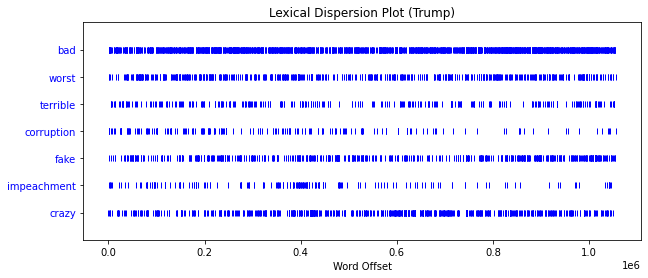

In [45]:
from nltk.draw.dispersion import dispersion_plot

# the following command can be used to increase the size of the plot using width and hight specifications
plt.figure(figsize=(10, 4))
targets=['bad','worst','terrible','corruption','fake','impeachment', 'crazy']
dispersion_plot(TTC, targets, ignore_case=True, title='Lexical Dispersion Plot (Trump)')

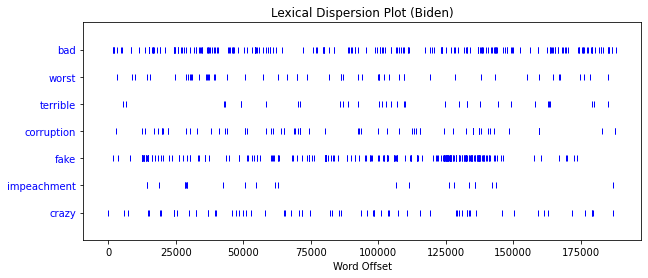

In [46]:
from nltk.draw.dispersion import dispersion_plot

# the following command can be used to increase the size of the plot using width and hight specifications
plt.figure(figsize=(10, 4))
targets=['bad','worst','terrible','corruption','fake','impeachment', 'crazy']
dispersion_plot(TBC, targets, ignore_case=True, title='Lexical Dispersion Plot (Biden)')

In [123]:
# Election day
import datetime as dt
election_day = P_daily_hscore.index[-5][0]
print('Election day is: {}'.format(election_day))
d_T = datetime.strptime(P_daily_hscore.index[-5][0], '%Y-%m-%d') #Få det på rigtige format til operations
# Let us view the 33 days of data available before electionday as our reference
d_m = (d_T- dt.timedelta(days=33)).strftime('%Y-%m-%d') #string format
d_m


Election day is: 2020-11-03


'2020-10-01'

In [124]:
l = documents_per_day.loc[election_day]
# for trump
l_ref = np.concatenate(documents_per_day[(documents_per_day.index < election_day) & \
                                (documents_per_day.index > d_m)].values)

In [125]:
from collections import Counter
p_l = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_lref = dict([(item[0], item[1]/len(l)) for item in Counter(l_ref).items()])
# Looking at top words
sorted(p_lref.items(), key = lambda x:x[1], reverse=True)[:10]

[('trump', 8.267733721353219),
 ('like', 3.6751546016733356),
 ('people', 3.580938523099309),
 ('would', 3.250272826482357),
 ('get', 2.3528555838486724),
 ('one', 2.23463077482721),
 ('going', 1.8992360858493997),
 ('even', 1.840669334303383),
 ('think', 1.8384867224445254),
 ('president', 1.7606402328119317)]

In [126]:
#Folk snakker rigtig meget om trump og people og voting både på dagen og før, men election på election day
# Tror det er fint? Synes det er lidt weird tho - Jakob
sorted(p_l.items(), key = lambda x:x[1], reverse=True)[:10]

[('trump', 0.01709712622771917),
 ('would', 0.011276827937431793),
 ('like', 0.009821753364859949),
 ('people', 0.008366678792288106),
 ('prison', 0.0061840669334303384),
 ('right', 0.005820298290287377),
 ('go', 0.005456529647144416),
 ('vote', 0.005456529647144416),
 ('think', 0.004728992360858494),
 ('get', 0.004728992360858494)]

In [127]:
# [(token, diff(p_l, p_lref))]
# Do it for every word in the union of sets of words for corpora
d_p = dict([(token, p_l.get(token, 0) -  p_lref.get(token, 0)) \
               for token in set(p_l.keys()).union(set(p_lref.keys()))])
sorted(d_p.items(), key = lambda x:x[1], reverse=True)[:10]

[('prepaid', 0.000727537286285922),
 ('magna', 0.0003637686431429611),
 ('compensators', 0.0003637686431429611),
 ('altawstwmih', 0.0003637686431429611),
 ('theron', 0.0003637686431429611),
 ('addendum', 0.0003637686431429611),
 ('woodie', 0.0003637686431429611),
 ('ethnics', 0.0003637686431429611),
 ('refunded', 0.0003637686431429611),
 ('fencing', 0.0003637686431429611)]

In [128]:
labMT_dict = pd.Series(labMT["Happiness Score"].values, index=labMT.index).to_dict()

prep_hscore =  dict([(token, labMT_dict.get(token, np.nan)-5) for token in set(p_l.keys()).union(set(p_lref.keys()))])
#Product
d_phi = dict([(token, prep_hscore[token]*d_p[token]) for token in set(p_l.keys()).union(set(p_lref.keys()))\
                    if not np.isnan(prep_hscore[token])]) #Do it for everything that isn't NaN

# Absolute value sorting top 10
sorted(d_phi.items(), key = lambda x: np.abs(x[1]), reverse=True)[:10]

[('like', -8.137038923244814),
 ('people', -4.144183339396145),
 ('covid', 4.133430338304838),
 ('shit', 2.735540196435067),
 ('good', -2.512113495816661),
 ('trump', -2.4751909785376482),
 ('right', -2.3035576573299386),
 ('think', -2.2005092761004006),
 ('get', -2.160276464168789),
 ('well', -2.0381229538013823)]

C:\Users\JaQtae\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


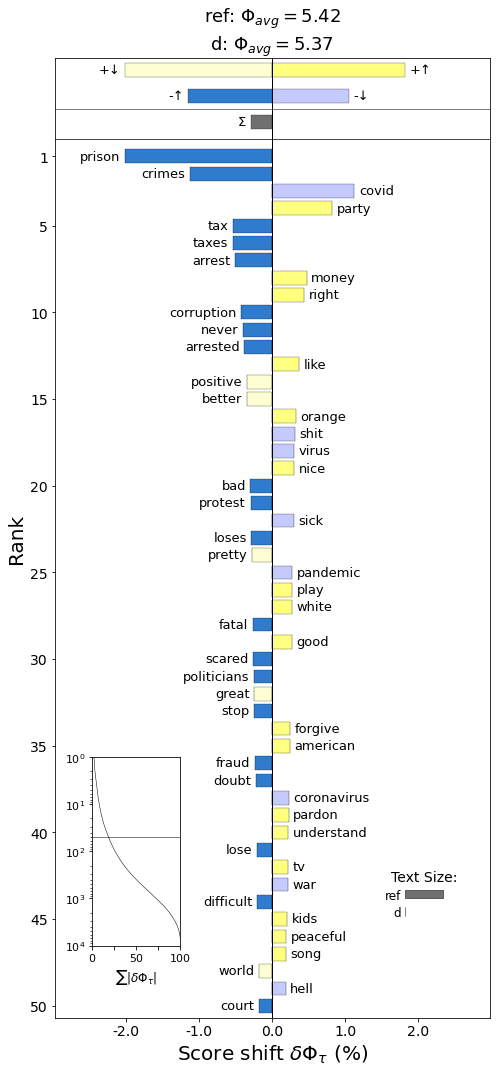

<AxesSubplot:title={'center':'ref: $\\Phi_{avg}=$5.42\nd: $\\Phi_{avg}=$5.37'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [129]:
import shifterator as sft
senti_shift = sft.WeightedAvgShift(type2freq_1 = p_lref,
                                     type2freq_2 = p_l,
                                     type2score_1 = labMT_dict,
                                     reference_value = 5)
senti_shift.get_shift_graph(detailed = True,
                            system_names = ['ref', 'd'])